# ⚡ Speed Optimizations Applied

This notebook now includes several optimizations to significantly reduce training time:

## 🚀 Active Optimizations

1. **Mixed Precision (FP16)** - 2-3x faster on modern GPUs
   - Automatically enabled for CUDA GPUs
   - Uses less VRAM, allowing larger batch sizes

2. **Larger Batch Size** - 1.5-2x faster
   - Auto-scales to 32 for GPUs with 16GB+ VRAM
   - More samples per iteration = fewer iterations

3. **Parallel Data Loading** - 10-20% faster
   - Uses 2 workers to load data while GPU trains
   - `persistent_workers=True` keeps workers alive

4. **Reduced Evaluation** - 50% less evaluation time
   - Evaluates 1x per epoch (was 2x)
   - Still captures model performance trends

5. **Phase Checkpointing** - Resume from crashes
   - Saves after each curriculum phase
   - No need to restart from scratch

## 📊 Expected Results

| Config | Original Time | Optimized Time | Speedup |
|--------|--------------|----------------|---------|
| Phase 1 (2 epochs) | ~3.5 hours | **~1.0 hour** | **3.5x** |
| Phase 2 (2 epochs) | ~7.0 hours | **~2.0 hours** | **3.5x** |
| **Total** | **~10.5 hours** | **~3.0 hours** | **3.5x** |

## 🎛️ Further Speed Options (if needed)

If you need even faster training, you can adjust in Cell 5:

```python
# Reduce training pairs (faster but potentially lower quality)
'num_pairs': 30000,  # Was 50000 (40% faster)

# Reduce sequence length (faster encoding)
'max_seq_length': 384,  # Was 512 (25% faster)

# Increase batch size (if you have VRAM headroom)
'batch_size': 64,  # Was 32 (2x faster if memory allows)
```

# 🚀 ITSM Ticket Similarity - Real ServiceNow Data Training (V2)

**Model:** `nomic-ai/nomic-embed-text-v1.5` (768-dim embeddings, 8192 token context)  
**Data:** Real ServiceNow incidents (Mar 2024 → Sep 2025, ~30K+ tickets)  
**Use Case:** Find similar tickets, detect duplicates, assist routing

## V2 Improvements over V1
1. **Harder negative mining** — Increased hard_neg_ratio (35%→45%), stricter TF-IDF threshold (0.20→0.12)
2. **Curriculum learning** — Progressive difficulty: easy pairs first, hard pairs later
3. **Borderline test set** — New "adversarial v2" with TF-IDF 0.25-0.35 (ambiguous cases)
4. **Error analysis** — Systematic failure pattern detection
5. **Cross-validated threshold** — 5-fold CV for robust production threshold

## Key Differences from Dummy Data Pipeline
1. **No Short Description** — Real data only has `Description` field
2. **Rich vocabulary** — 10K+ unique terms vs 111 in dummy data
3. **Realistic metrics expected** — ROC-AUC 0.85-0.90, Spearman 0.65-0.75
4. **No Resolution notes in training text** — Avoids data leakage for new tickets

# 1. Environment Setup

In [1]:
import os, sys, subprocess
from pathlib import Path

# Environment variables to suppress warnings
os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_SILENT'] = 'true'
os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Install required packages
def ensure_packages():
    try:
        import importlib.metadata as importlib_metadata
    except ImportError:
        import importlib_metadata
    
    required = {
        'sentence-transformers': 'sentence-transformers>=2.2.2',
        'torch': 'torch',
        'scikit-learn': 'scikit-learn>=1.3.0',
        'pandas': 'pandas',
        'numpy': 'numpy>=1.24.0',
        'tqdm': 'tqdm',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn',
        'einops': 'einops',
    }
    
    missing = []
    for name, spec in required.items():
        try:
            importlib_metadata.version(name)
        except importlib_metadata.PackageNotFoundError:
            missing.append(spec)
    
    if missing:
        print(f'📦 Installing: {", ".join(missing)}')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', *missing])
    else:
        print('✅ All packages installed')

ensure_packages()

✅ All packages installed


# 2. Configuration

In [2]:
import random
import numpy as np
import torch
import logging
import json

# Simple logging
def log(msg, level=logging.INFO):
    print(msg)

# --- CONFIGURATION (V2 - Improved) ---
CONFIG = {
    # Model - Using Nomic Embed v1.5 (768-dim, 8192 token context)
    'model_name': 'nomic-ai/nomic-embed-text-v1.5',
    'output_dir': 'models/real_servicenow_finetuned_nomic',
    
    # Data
    'source_data': 'data_new\\SNow_incident_ticket_data.csv',
    
    # Training hyperparameters
    'epochs': 4,              # Real data needs fewer epochs (more signal)
    'batch_size': 16,         # Will auto-increase based on GPU memory
    'lr': 2e-5,
    'max_seq_length': 512,    # Nomic supports up to 8192, but 512 is good for ITSM tickets
    'warmup_ratio': 0.1,
    
    # SPEED OPTIMIZATIONS
    'use_fp16': True,         # Mixed precision training (2-3x faster on modern GPUs)
    'dataloader_workers': 2,  # Parallel data loading (was 0)
    'eval_frequency': 0.5,    # Evaluate once per epoch (was 2x per epoch)
    
    # Pair generation (V2: HARDER NEGATIVES)
    'num_pairs': 50000,       # 50K pairs for real data
    'pos_ratio': 0.30,        # 30% positives (reduced from 35%)
    'hard_neg_ratio': 0.45,   # 45% hard negatives (increased from 35%)
    'easy_neg_ratio': 0.25,   # 25% easy negatives (reduced from 30%)
    'pos_tfidf_threshold': 0.35,   # Lower threshold for real data (more variety)
    'neg_tfidf_threshold': 0.12,   # STRICTER: Upper bound for negatives (was 0.20)
    
    # Curriculum learning (V2: NEW)
    'use_curriculum': True,
    'curriculum_phases': [
        {'epochs': 2, 'hard_neg_ratio': 0.25, 'neg_threshold': 0.15},  # Phase 1: Easier
        {'epochs': 2, 'hard_neg_ratio': 0.55, 'neg_threshold': 0.10},  # Phase 2: Harder
    ],
    
    # Data splits
    'eval_split': 0.15,
    'holdout_split': 0.10,
    
    # Minimum text length (filter short descriptions)
    'min_text_length': 25,
    
    # Cross-validation for threshold (V2: NEW)
    'threshold_cv_folds': 5,
    
    # Seed
    'seed': 42
}

# Set seeds for reproducibility
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])

# Device detection: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = 'cuda'
    torch.cuda.manual_seed_all(CONFIG['seed'])
    log(f"🚀 CUDA Detected: {torch.cuda.get_device_name(0)}")
    
    # Auto-increase batch size if GPU has enough memory
    gpu_props = torch.cuda.get_device_properties(0)
    gpu_mem_gb = gpu_props.total_memory / 1024**3
    if gpu_mem_gb >= 16:
        CONFIG['batch_size'] = 32  # Larger batch for GPUs with 16GB+ VRAM
        log(f"   GPU Memory: {gpu_mem_gb:.1f}GB - Using batch_size=32")
    else:
        log(f"   GPU Memory: {gpu_mem_gb:.1f}GB - Using batch_size=16")
    
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = 'mps'
    torch.mps.manual_seed(CONFIG['seed'])
    log("🍎 MPS (Apple Silicon) Detected")
    CONFIG['batch_size'] = 8  # Reduce for MPS memory
    CONFIG['use_fp16'] = False  # MPS doesn't fully support FP16 yet
else:
    DEVICE = 'cpu'
    log("⚠️ No GPU detected. Running on CPU.")
    CONFIG['batch_size'] = 8
    CONFIG['use_fp16'] = False  # CPU doesn't support FP16

log(f"📊 Device: {DEVICE}, Batch Size: {CONFIG['batch_size']}")
log(f"\n🆕 V2 Improvements Active:")
log(f"   • Harder negatives: {CONFIG['hard_neg_ratio']*100:.0f}% hard neg ratio")
log(f"   • Curriculum learning phases: {len(CONFIG['curriculum_phases'])}")
log(f"   • Hard neg threshold: {CONFIG['neg_tfidf_threshold']}")

🚀 CUDA Detected: NVIDIA GeForce RTX 2080 SUPER
   GPU Memory: 8.0GB - Using batch_size=16
📊 Device: cuda, Batch Size: 16

🆕 V2 Improvements Active:
   • Harder negatives: 45% hard neg ratio
   • Curriculum learning phases: 2
   • Hard neg threshold: 0.12


# 3. Data Loading & Preprocessing

Load real ServiceNow incident data. Key differences from dummy data:
- Only `Description` field (no Short Description)
- Multi-line text with embedded newlines
- Rich technical vocabulary

In [3]:
import pandas as pd
import re
from pathlib import Path

def load_and_preprocess_real_data(config):
    """
    Load and preprocess real ServiceNow incident data.
    
    Key differences from dummy data:
    - Only 'Description' column (no 'Short Description')
    - Real data has multi-line descriptions with embedded newlines
    - Richer vocabulary and more varied text
    """
    source_path = Path(config['source_data'])
    
    # Debug: Show absolute path
    log(f"🔍 Looking for data file:")
    log(f"   Configured path: {config['source_data']}")
    log(f"   Absolute path: {source_path.resolve()}")
    log(f"   Current working directory: {Path.cwd()}")
    log(f"   File exists: {source_path.exists()}")
    
    if not source_path.exists():
        raise FileNotFoundError(f"Data file not found: {source_path.resolve()}")
    
    log(f"📂 Loading real ServiceNow data from: {source_path}")
    
    # Load CSV - handle multi-line fields
    df = pd.read_csv(source_path, encoding='utf-8', on_bad_lines='skip')
    initial_count = len(df)
    log(f"📊 Loaded {initial_count:,} raw records")
    
    # Check required columns
    required_cols = ['Number', 'Description', 'Category', 'Subcategory', 
                     'Service', 'Service offering', 'Assignment group']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        log(f"⚠️ Missing columns: {missing_cols}")
        # Use available columns
        required_cols = [col for col in required_cols if col in df.columns]
    
    log(f"✅ Available columns: {list(df.columns)}")
    
    # Clean text function
    def clean_text(text):
        if pd.isna(text) or text is None:
            return ""
        text = str(text).strip()
        # Normalize whitespace (collapse multiple spaces/newlines)
        text = re.sub(r'\s+', ' ', text)
        # Remove common boilerplate
        text = re.sub(r'Note\s*:\s*This is an automated.*?\.', '', text, flags=re.IGNORECASE)
        return text.strip()
    
    # Clean Description
    df['Description'] = df['Description'].apply(clean_text)
    
    # Fill NA for context columns
    context_cols = ['Category', 'Subcategory', 'Service', 'Service offering', 'Assignment group']
    for col in context_cols:
        if col in df.columns:
            df[col] = df[col].fillna('').astype(str).str.strip().str.lower()
    
    # Build contextual text representation
    # Format: "Description (Context: [Service|Offering] [Category|Subcategory] Group: X)"
    def build_context(row):
        parts = []
        
        # Service context
        service_parts = []
        if row.get('Service', ''):
            service_parts.append(row['Service'])
        if row.get('Service offering', ''):
            service_parts.append(row['Service offering'])
        if service_parts:
            parts.append(f"[{' | '.join(service_parts)}]")
        
        # Category context
        cat_parts = []
        if row.get('Category', ''):
            cat_parts.append(row['Category'])
        if row.get('Subcategory', ''):
            cat_parts.append(row['Subcategory'])
        if cat_parts:
            parts.append(f"[{' | '.join(cat_parts)}]")
        
        # Assignment group
        if row.get('Assignment group', ''):
            parts.append(f"Group: {row['Assignment group']}")
        
        return ' '.join(parts) if parts else ''
    
    # Build full text: Description + Context suffix
    df['context'] = df.apply(build_context, axis=1)
    df['text'] = df.apply(
        lambda row: f"{row['Description']} (Context: {row['context']})" if row['context'] else row['Description'],
        axis=1
    )
    
    # Filter out short/empty descriptions
    df = df[df['Description'].str.len() >= config['min_text_length']].copy()
    log(f"📉 After filtering short descriptions: {len(df):,} records (dropped {initial_count - len(df):,})")
    
    # Create category_id for stratified splitting
    if 'Category' in df.columns and 'Subcategory' in df.columns:
        df['category_id'] = df.groupby(['Category', 'Subcategory']).ngroup()
    else:
        df['category_id'] = 0
    
    # Reset index
    df = df.reset_index(drop=True)
    
    # Summary stats
    log(f"\n📊 Data Summary:")
    log(f"   Total records: {len(df):,}")
    log(f"   Unique categories: {df['category_id'].nunique()}")
    log(f"   Avg text length: {df['text'].str.len().mean():.0f} chars")
    log(f"   Min text length: {df['text'].str.len().min()} chars")
    log(f"   Max text length: {df['text'].str.len().max()} chars")
    
    # Sample text
    log(f"\n📝 Sample preprocessed text:")
    log(f"   '{df['text'].iloc[0][:200]}...'")
    
    return df

# Load the data
df_incidents = load_and_preprocess_real_data(CONFIG)
print(f"\n✅ Loaded {len(df_incidents):,} incidents ready for training")

🔍 Looking for data file:
   Configured path: data_new\SNow_incident_ticket_data.csv
   Absolute path: C:\Users\donov\Downloads\nexustism\nexustism\data_new\SNow_incident_ticket_data.csv
   Current working directory: c:\Users\donov\Downloads\nexustism\nexustism
   File exists: True
📂 Loading real ServiceNow data from: data_new\SNow_incident_ticket_data.csv
📊 Loaded 10,633 raw records
✅ Available columns: ['Number', 'Description', 'Opened by', 'Company', 'ITSM Department', 'Created', 'Urgency', 'Impact', 'Priority', 'Assignment group', 'Assigned to', 'State', 'Service', 'Service offering', 'Closed', 'Closed by', 'Category', 'Subcategory', 'Resolution code', 'Resolution notes', 'User input', 'Comments and Work notes', 'Manday Effort (hrs)', 'Ticket Type', 'AMS Domain', 'AMS System Type', 'AMS Category Type', 'AMS Service Type', 'AMS Business Related', 'AMS IT Related']
📉 After filtering short descriptions: 10,486 records (dropped 147)

📊 Data Summary:
   Total records: 10,486
   Unique ca

# 4. Data Splitting

Split into Train / Eval / Holdout sets with stratification by category.

In [4]:
from sklearn.model_selection import train_test_split

def split_data(df, config):
    """
    Three-way split: Train / Eval / Holdout
    - Holdout is completely unseen (for adversarial diagnostic)
    - Stratified by category to ensure representation
    """
    # Handle rare categories: group categories with <2 samples
    category_counts = df['category_id'].value_counts()
    rare_categories = category_counts[category_counts < 2].index
    
    # Create stratification column: use category_id for common categories, -1 for rare
    df['stratify_col'] = df['category_id'].copy()
    df.loc[df['category_id'].isin(rare_categories), 'stratify_col'] = -1
    
    # Check if we can stratify (need at least 2 samples per class)
    stratify_counts = df['stratify_col'].value_counts()
    can_stratify = all(stratify_counts >= 2)
    
    if can_stratify:
        # First split: separate holdout set (stratified)
        train_eval_df, holdout_df = train_test_split(
            df,
            test_size=config['holdout_split'],
            stratify=df['stratify_col'],
            random_state=config['seed']
        )
        
        # Second split: train/eval from remaining (stratified)
        train_df, eval_df = train_test_split(
            train_eval_df,
            test_size=config['eval_split'],
            stratify=train_eval_df['stratify_col'],
            random_state=config['seed']
        )
        log("✅ Using stratified split")
    else:
        # Fallback: random split without stratification
        log("⚠️ Using random split (categories too imbalanced for stratification)")
        train_eval_df, holdout_df = train_test_split(
            df,
            test_size=config['holdout_split'],
            random_state=config['seed']
        )
        
        train_df, eval_df = train_test_split(
            train_eval_df,
            test_size=config['eval_split'],
            random_state=config['seed']
        )
    
    return train_df, eval_df, holdout_df

# Split the data
train_df, eval_df, holdout_df = split_data(df_incidents, CONFIG)

log(f"📊 Data Splits:")
log(f"   Train:   {len(train_df):,} incidents ({len(train_df)/len(df_incidents)*100:.1f}%)")
log(f"   Eval:    {len(eval_df):,} incidents ({len(eval_df)/len(df_incidents)*100:.1f}%)")
log(f"   Holdout: {len(holdout_df):,} incidents ({len(holdout_df)/len(df_incidents)*100:.1f}%)")

# Check for data leakage
def check_overlap(df1, df2, name1, name2):
    overlap = len(set(df1['Number']) & set(df2['Number']))
    log(f"   {name1} ∩ {name2}: {overlap} incidents")

log(f"\n🔍 Overlap Check:")
check_overlap(train_df, eval_df, "Train", "Eval")
check_overlap(train_df, holdout_df, "Train", "Holdout")
check_overlap(eval_df, holdout_df, "Eval", "Holdout")

✅ Using stratified split
📊 Data Splits:
   Train:   8,021 incidents (76.5%)
   Eval:    1,416 incidents (13.5%)
   Holdout: 1,049 incidents (10.0%)

🔍 Overlap Check:
   Train ∩ Eval: 0 incidents
   Train ∩ Holdout: 0 incidents
   Eval ∩ Holdout: 0 incidents


# 5. Pair Generation

Generate training pairs using TF-IDF similarity mining:
- **35% Positives**: High TF-IDF similarity (> 0.35)
- **35% Hard Negatives**: Same category, low TF-IDF (< 0.20)
- **30% Easy Negatives**: Different category, low TF-IDF

This forces the model to learn semantic content, not just category matching.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import InputExample
from tqdm.auto import tqdm
import gc

class TFIDFSimilarityCalculator:
    """Efficient TF-IDF similarity calculator for large datasets."""
    
    def __init__(self, texts, max_features=15000):
        log("⏳ Building TF-IDF matrix...")
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2),  # Unigrams + bigrams for better matching
            min_df=2,           # Ignore very rare terms
            max_df=0.95         # Ignore very common terms
        )
        self.tfidf_matrix = self.vectorizer.fit_transform(texts)
        log(f"✅ TF-IDF matrix: {self.tfidf_matrix.shape} (vocab size: {len(self.vectorizer.vocabulary_)})")
    
    def similarity(self, idx1, idx2):
        """Compute cosine similarity between two documents."""
        if idx1 >= self.tfidf_matrix.shape[0] or idx2 >= self.tfidf_matrix.shape[0]:
            return 0.0
        vec1 = self.tfidf_matrix[idx1]
        vec2 = self.tfidf_matrix[idx2]
        return (vec1 @ vec2.T).toarray()[0][0]


def generate_training_pairs(df, target_count, config, desc="", phase_config=None, tfidf_calc=None):
    """Generate training pairs with configurable split (supports curriculum phases)."""
    df = df.reset_index(drop=True)
    
    # Use phase config if provided (for curriculum learning)
    pos_ratio = config['pos_ratio']
    hard_neg_ratio = phase_config['hard_neg_ratio'] if phase_config else config['hard_neg_ratio']
    neg_threshold = phase_config['neg_threshold'] if phase_config else config['neg_tfidf_threshold']
    easy_neg_ratio = 1.0 - pos_ratio - hard_neg_ratio
    
    # Build TF-IDF once unless a calculator is provided
    created_local = tfidf_calc is None
    tfidf_calc = tfidf_calc or TFIDFSimilarityCalculator(df['text'].tolist())
    
    # Calculate targets
    pos_target = int(target_count * pos_ratio)
    hard_neg_target = int(target_count * hard_neg_ratio)
    easy_neg_target = target_count - pos_target - hard_neg_target
    
    pairs = []
    all_indices = list(df.index)
    
    # Group by category for hard negatives
    category_groups = df.groupby('category_id').indices
    valid_groups = {k: list(v) for k, v in category_groups.items() if len(v) >= 2}
    
    log(f"\n🎯 Generating {target_count:,} pairs for {desc}:")
    log(f"   Target: {pos_target:,} positives ({pos_ratio*100:.0f}%), {hard_neg_target:,} hard neg ({hard_neg_ratio*100:.0f}%), {easy_neg_target:,} easy neg")
    log(f"   Neg TF-IDF threshold: {neg_threshold}")
    
    # ============================================
    # 1. POSITIVES: High TF-IDF similarity (> threshold)
    # ============================================
    pbar = tqdm(total=pos_target, desc="Positives (high TF-IDF)")
    attempts, max_attempts = 0, pos_target * 50
    
    while len(pairs) < pos_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        if i1 == i2:
            continue
        
        sim = tfidf_calc.similarity(i1, i2)
        if sim > config['pos_tfidf_threshold']:
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=1.0
            ))
            pbar.update(1)
    pbar.close()
    actual_pos = len(pairs)
    
    # ============================================
    # 2. HARD NEGATIVES: Same category, low TF-IDF (stricter threshold)
    # ============================================
    current_len = len(pairs)
    pbar = tqdm(total=hard_neg_target, desc=f"Hard Negatives (same cat, TF-IDF<{neg_threshold})")
    attempts, max_attempts = 0, hard_neg_target * 50
    
    while (len(pairs) - current_len) < hard_neg_target and attempts < max_attempts:
        attempts += 1
        if not valid_groups:
            break
        
        # Pick a random category with 2+ members
        gid = random.choice(list(valid_groups.keys()))
        g_indices = valid_groups[gid]
        if len(g_indices) < 2:
            continue
        
        i1, i2 = random.sample(g_indices, 2)
        sim = tfidf_calc.similarity(i1, i2)
        
        if sim < neg_threshold:
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=0.0
            ))
            pbar.update(1)
    pbar.close()
    actual_hard = len(pairs) - current_len
    
    # ============================================
    # 3. EASY NEGATIVES: Cross-category, low TF-IDF
    # ============================================
    current_len = len(pairs)
    pbar = tqdm(total=easy_neg_target, desc="Easy Negatives (cross-cat)")
    attempts, max_attempts = 0, easy_neg_target * 50
    
    while (len(pairs) - current_len) < easy_neg_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        
        # Must be different categories
        if df.at[i1, 'category_id'] == df.at[i2, 'category_id']:
            continue
        
        sim = tfidf_calc.similarity(i1, i2)
        if sim < neg_threshold:
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=0.0
            ))
            pbar.update(1)
    pbar.close()
    actual_easy = len(pairs) - current_len
    
    # Summary
    total_pos = sum(1 for p in pairs if p.label == 1.0)
    total_neg = len(pairs) - total_pos
    
    log(f"✅ Generated {len(pairs):,} pairs:")
    log(f"   Positives: {actual_pos:,} ({actual_pos/len(pairs)*100:.1f}%)")
    log(f"   Hard Neg:  {actual_hard:,} ({actual_hard/len(pairs)*100:.1f}%)")
    log(f"   Easy Neg:  {actual_easy:,} ({actual_easy/len(pairs)*100:.1f}%)")
    
    # Clean up only if we created the calculator
    if created_local:
        del tfidf_calc
        gc.collect()
    
    return pairs


def generate_borderline_pairs(df, target_count, config, desc="Borderline", tfidf_calc=None):
    """Generate borderline/ambiguous pairs for harder evaluation."""
    df = df.reset_index(drop=True)
    created_local = tfidf_calc is None
    tfidf_calc = tfidf_calc or TFIDFSimilarityCalculator(df['text'].tolist())
    
    borderline_pairs = []
    all_indices = list(df.index)
    
    # TF-IDF range for borderline cases
    low_threshold = 0.25
    high_threshold = 0.35
    
    log(f"\n🎯 Generating {target_count:,} borderline pairs ({desc}):")
    log(f"   TF-IDF range: {low_threshold} - {high_threshold}")
    
    pbar = tqdm(total=target_count, desc="Borderline pairs")
    attempts, max_attempts = 0, target_count * 100
    
    while len(borderline_pairs) < target_count and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        if i1 == i2:
            continue
        
        sim = tfidf_calc.similarity(i1, i2)
        
        # Borderline: medium TF-IDF similarity (ambiguous)
        if low_threshold <= sim <= high_threshold:
            same_cat = df.at[i1, 'category_id'] == df.at[i2, 'category_id']
            label = 1.0 if same_cat else 0.0
            
            borderline_pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=label
            ))
            pbar.update(1)
    
    pbar.close()
    
    pos_count = sum(1 for p in borderline_pairs if p.label == 1.0)
    log(f"✅ Generated {len(borderline_pairs):,} borderline pairs:")
    log(f"   Positives: {pos_count:,} ({pos_count/len(borderline_pairs)*100:.1f}%)")
    log(f"   Negatives: {len(borderline_pairs)-pos_count:,}")
    
    if created_local:
        del tfidf_calc
        gc.collect()
    
    return borderline_pairs

c:\Users\donov\anaconda3\envs\itsm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️  Running in WANDB offline mode


In [6]:
# Generate pairs for each split
# Scale pair counts based on split sizes
train_pair_count = int(CONFIG['num_pairs'] * 0.75)  # 75% for training
eval_pair_count = int(CONFIG['num_pairs'] * 0.15)   # 15% for eval
holdout_pair_count = int(CONFIG['num_pairs'] * 0.10) # 10% for holdout

# Build TF-IDF calculators once per split
tfidf_train = TFIDFSimilarityCalculator(train_df['text'].tolist())
tfidf_eval = TFIDFSimilarityCalculator(eval_df['text'].tolist())
tfidf_holdout = TFIDFSimilarityCalculator(holdout_df['text'].tolist())

train_examples = generate_training_pairs(train_df, train_pair_count, CONFIG, desc="Training", tfidf_calc=tfidf_train)
eval_examples = generate_training_pairs(eval_df, eval_pair_count, CONFIG, desc="Evaluation", tfidf_calc=tfidf_eval)
holdout_examples = generate_training_pairs(holdout_df, holdout_pair_count, CONFIG, desc="Holdout", tfidf_calc=tfidf_holdout)

# V2 NEW: Generate borderline test set for harder evaluation
borderline_count = int(CONFIG['num_pairs'] * 0.05)  # 5% as borderline test
borderline_examples = generate_borderline_pairs(holdout_df, borderline_count, CONFIG, desc="Borderline Test", tfidf_calc=tfidf_holdout)

log(f"\n📦 Final Pair Counts:")
log(f"   Train:      {len(train_examples):,}")
log(f"   Eval:       {len(eval_examples):,}")
log(f"   Holdout:    {len(holdout_examples):,}")
log(f"   Borderline: {len(borderline_examples):,} (V2 NEW - harder test)")

⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (8021, 15000) (vocab size: 15000)
⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (1416, 5532) (vocab size: 5532)
⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (1049, 5256) (vocab size: 5256)

🎯 Generating 37,500 pairs for Training:
   Target: 11,250 positives (30%), 16,875 hard neg (45%), 9,375 easy neg
   Neg TF-IDF threshold: 0.12


Easy Negatives (cross-cat): 100%|██████████| 9375/9375 [00:03<00:00, 2926.39it/s]


✅ Generated 33,216 pairs:
   Positives: 6,966 (21.0%)
   Hard Neg:  16,875 (50.8%)
   Easy Neg:  9,375 (28.2%)

🎯 Generating 7,500 pairs for Evaluation:
   Target: 2,250 positives (30%), 3,375 hard neg (45%), 1,875 easy neg
   Neg TF-IDF threshold: 0.12


Easy Negatives (cross-cat): 100%|██████████| 1875/1875 [00:00<00:00, 2582.60it/s]


✅ Generated 7,480 pairs:
   Positives: 2,230 (29.8%)
   Hard Neg:  3,375 (45.1%)
   Easy Neg:  1,875 (25.1%)

🎯 Generating 5,000 pairs for Holdout:
   Target: 1,500 positives (30%), 2,250 hard neg (45%), 1,250 easy neg
   Neg TF-IDF threshold: 0.12


Easy Negatives (cross-cat): 100%|██████████| 1250/1250 [00:00<00:00, 2454.60it/s]


✅ Generated 5,000 pairs:
   Positives: 1,500 (30.0%)
   Hard Neg:  2,250 (45.0%)
   Easy Neg:  1,250 (25.0%)

🎯 Generating 2,500 borderline pairs (Borderline Test):
   TF-IDF range: 0.25 - 0.35


Borderline pairs: 100%|██████████| 2500/2500 [00:21<00:00, 118.90it/s]

✅ Generated 2,500 borderline pairs:
   Positives: 727 (29.1%)
   Negatives: 1,773

📦 Final Pair Counts:
   Train:      33,216
   Eval:       7,480
   Holdout:    5,000
   Borderline: 2,500 (V2 NEW - harder test)


# 6. Model Training (V2: Curriculum Learning)

Train `all-mpnet-base-v2` with MultipleNegativesRankingLoss.

**V2 Curriculum Strategy:**
- **Phase 1 (Epochs 1-2):** Easier pairs (25% hard negatives, threshold 0.15)
- **Phase 2 (Epochs 3-4):** Harder pairs (55% hard negatives, threshold 0.10)

This progressive difficulty helps the model learn basic patterns first, then refine on edge cases.

In [7]:
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import SentenceEvaluator
from torch.utils.data import DataLoader
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import KFold
from datetime import datetime
import gc

# --- Custom Evaluator ---
class ITSMEvaluator(SentenceEvaluator):
    """Evaluator for ITSM ticket similarity."""
    
    def __init__(self, examples, batch_size=16, name=""):
        self.examples = examples
        self.batch_size = batch_size
        self.name = name
        
        self.texts1 = [ex.texts[0] for ex in examples]
        self.texts2 = [ex.texts[1] for ex in examples]
        self.labels = np.array([ex.label for ex in examples])
        
        self.csv_file = f"{name}_eval_results.csv"
        self.csv_headers = ["epoch", "steps", "spearman", "pearson", "roc_auc", "pr_auc"]
    
    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        model.eval()
        
        # Encode pairs
        emb1 = model.encode(self.texts1, batch_size=self.batch_size, 
                          show_progress_bar=False, convert_to_numpy=True)
        emb2 = model.encode(self.texts2, batch_size=self.batch_size, 
                          show_progress_bar=False, convert_to_numpy=True)
        
        # Compute cosine similarity
        scores = np.sum(emb1 * emb2, axis=1) / (
            np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1) + 1e-8
        )
        
        # Compute metrics
        spearman, _ = spearmanr(self.labels, scores)
        pearson, _ = pearsonr(self.labels, scores)
        
        try:
            roc_auc = roc_auc_score(self.labels, scores)
            pr_auc = average_precision_score(self.labels, scores)
        except ValueError:
            roc_auc, pr_auc = 0.0, 0.0
        
        log(f"  [{self.name}] Epoch {epoch}: Spearman={spearman:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
        
        # Save to CSV
        if output_path:
            csv_path = Path(output_path) / self.csv_file
            if not csv_path.exists():
                with open(csv_path, 'w') as f:
                    f.write(','.join(self.csv_headers) + '\n')
            with open(csv_path, 'a') as f:
                f.write(f"{epoch},{steps},{spearman},{pearson},{roc_auc},{pr_auc}\n")
        
        return spearman  # Primary metric


# --- Model Initialization ---
def init_model(config, device):
    """Initialize model with GPU memory management."""
    # Clear GPU memory
    if device == 'cuda':
        torch.cuda.empty_cache()
    elif device == 'mps':
        torch.mps.empty_cache()
    gc.collect()
    
    log(f"🔧 Loading model: {config['model_name']}")
    model = SentenceTransformer(config['model_name'], device=device, trust_remote_code=True)
    model.max_seq_length = config['max_seq_length']
    log(f"✅ Model loaded on {device}, max_seq_length={model.max_seq_length}")
    
    return model


# --- V2: Cross-Validated Threshold Selection ---
def get_cv_threshold(examples, model, n_folds=5):
    """
    V2 NEW: Use k-fold cross-validation to find robust threshold.
    
    Returns the average best threshold across folds.
    """
    from sklearn.metrics import precision_recall_curve, f1_score
    
    texts1 = [ex.texts[0] for ex in examples]
    texts2 = [ex.texts[1] for ex in examples]
    labels = np.array([ex.label for ex in examples])
    
    # Encode all pairs
    emb1 = model.encode(texts1, batch_size=CONFIG['batch_size'], show_progress_bar=False)
    emb2 = model.encode(texts2, batch_size=CONFIG['batch_size'], show_progress_bar=False)
    scores = np.sum(emb1 * emb2, axis=1) / (np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1) + 1e-8)
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=CONFIG['seed'])
    best_thresholds = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(scores)):
        val_scores = scores[val_idx]
        val_labels = labels[val_idx]
        
        precision, recall, thresholds = precision_recall_curve(val_labels, val_scores)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx-1] if 0 < best_idx < len(thresholds)+1 else 0.5
        best_thresholds.append(best_threshold)
    
    avg_threshold = np.mean(best_thresholds)
    std_threshold = np.std(best_thresholds)
    
    log(f"📊 CV Threshold ({n_folds}-fold): {avg_threshold:.4f} ± {std_threshold:.4f}")
    log(f"   Per-fold thresholds: {[f'{t:.3f}' for t in best_thresholds]}")
    
    return avg_threshold, std_threshold


# Initialize model
model = init_model(CONFIG, DEVICE)

# Filter to positive pairs only for MNRL
log(f"📊 Filtering to positive pairs for MultipleNegativesRankingLoss...")
train_positives = [ex for ex in train_examples if ex.label == 1.0]
eval_positives = [ex for ex in eval_examples if ex.label == 1.0]

log(f"   Train positives: {len(train_positives):,} (was {len(train_examples):,} total)")
log(f"   Eval positives:  {len(eval_positives):,} (was {len(eval_examples):,} total)")

# Create DataLoader with speed optimizations
train_dataloader = DataLoader(
    train_positives,
    shuffle=True,
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['dataloader_workers'],  # Parallel data loading
    pin_memory=(DEVICE in ['cuda', 'mps']),
    persistent_workers=(CONFIG['dataloader_workers'] > 0)  # Keep workers alive
)

# Use MultipleNegativesRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)

log(f"🔧 Using MultipleNegativesRankingLoss (in-batch negatives)")
log(f"   Effective negatives per sample: {CONFIG['batch_size'] - 1}")

# Evaluator
evaluator = ITSMEvaluator(eval_examples, batch_size=CONFIG['batch_size'], name="eval")

log(f"\n📊 Training Setup:")
log(f"   Batches per epoch: {len(train_dataloader)}")
log(f"   Total training steps: {len(train_dataloader) * CONFIG['epochs']}")
log(f"   Warmup steps: {int(len(train_dataloader) * CONFIG['epochs'] * CONFIG['warmup_ratio'])}")
log(f"   Curriculum learning: {CONFIG['use_curriculum']}")


🔧 Loading model: nomic-ai/nomic-embed-text-v1.5


<All keys matched successfully>


✅ Model loaded on cuda, max_seq_length=512
📊 Filtering to positive pairs for MultipleNegativesRankingLoss...
   Train positives: 6,966 (was 33,216 total)
   Eval positives:  2,230 (was 7,480 total)
🔧 Using MultipleNegativesRankingLoss (in-batch negatives)
   Effective negatives per sample: 15

📊 Training Setup:
   Batches per epoch: 436
   Total training steps: 1744
   Warmup steps: 174
   Curriculum learning: True


In [9]:
# --- Training Execution (V2: with Curriculum Learning + Speed Optimizations) ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_path = Path(CONFIG['output_dir']) / f"real_servicenow_v2_{timestamp}"
save_path.mkdir(parents=True, exist_ok=True)

log(f"\n🚀 Starting Training (V2)...")
log(f"   Output: {save_path}")
log(f"   Epochs: {CONFIG['epochs']}")
log(f"   Device: {DEVICE}")
log(f"   Mixed Precision (FP16): {CONFIG['use_fp16']}")

# Calculate warmup steps
total_steps = len(train_dataloader) * CONFIG['epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
# Reduced evaluation frequency for speed
eval_steps = max(100, int(len(train_dataloader) / CONFIG['eval_frequency']))

log(f"   Evaluation frequency: every {eval_steps} steps (~{CONFIG['eval_frequency']}x per epoch)")

try:
    if CONFIG['use_curriculum']:
        # V2: Curriculum Learning - train in phases
        log("\n📚 CURRICULUM LEARNING ENABLED")
        
        for phase_idx, phase in enumerate(CONFIG['curriculum_phases']):
            log(f"\n{'='*60}")
            log(f"📚 Phase {phase_idx + 1}: {phase['epochs']} epochs")
            log(f"   Hard neg ratio: {phase['hard_neg_ratio']*100:.0f}%")
            log(f"   Neg threshold: {phase['neg_threshold']}")
            log(f"{'='*60}")
            
            # Regenerate training pairs for this phase (reuse TF-IDF)
            phase_train_examples = generate_training_pairs(
                train_df, 
                len(train_positives),  # Same count as original positives
                CONFIG, 
                desc=f"Phase {phase_idx+1}",
                phase_config=phase,
                tfidf_calc=tfidf_train
            )
            phase_positives = [ex for ex in phase_train_examples if ex.label == 1.0]
            
            phase_dataloader = DataLoader(
                phase_positives,
                shuffle=True,
                batch_size=CONFIG['batch_size'],
                num_workers=0,  # Fixed: Windows pickling issue with sentence-transformers
                pin_memory=(DEVICE in ['cuda', 'mps']),
                persistent_workers=False
            )
            
            phase_warmup = int(len(phase_dataloader) * phase['epochs'] * CONFIG['warmup_ratio'])
            
            # Create phase-specific checkpoint directory
            phase_checkpoint_dir = Path(save_path) / f"phase_{phase_idx + 1}_checkpoint"
            phase_checkpoint_dir.mkdir(parents=True, exist_ok=True)
            
            model.fit(
                train_objectives=[(phase_dataloader, train_loss)],
                evaluator=evaluator,
                epochs=phase['epochs'],
                warmup_steps=phase_warmup,
                optimizer_params={'lr': CONFIG['lr']},
                output_path=str(save_path),
                evaluation_steps=eval_steps,
                save_best_model=True,
                show_progress_bar=True,
                use_amp=CONFIG['use_fp16']  # Enable mixed precision training
            )
            
            # Save phase checkpoint
            log(f"💾 Saving Phase {phase_idx + 1} checkpoint...")
            model.save(str(phase_checkpoint_dir))
            
            # Also save phase metadata
            phase_metadata = {
                "phase": phase_idx + 1,
                "total_phases": len(CONFIG['curriculum_phases']),
                "phase_config": phase,
                "checkpoint_timestamp": datetime.now().isoformat(),
                "model_path": str(phase_checkpoint_dir)
            }
            with open(phase_checkpoint_dir / "phase_metadata.json", 'w') as f:
                json.dump(phase_metadata, f, indent=2)
            
            log(f"✅ Phase {phase_idx + 1} complete! Checkpoint saved to: {phase_checkpoint_dir}")
            
            # Clear GPU memory between phases
            if DEVICE == 'cuda':
                torch.cuda.empty_cache()
            elif DEVICE == 'mps':
                torch.mps.empty_cache()
            gc.collect()
            log(f"🧹 GPU memory cleared between phases")
    else:
        # Standard training (no curriculum)
        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=evaluator,
            epochs=CONFIG['epochs'],
            warmup_steps=warmup_steps,
            optimizer_params={'lr': CONFIG['lr']},
            output_path=str(save_path),
            evaluation_steps=eval_steps,
            save_best_model=True,
            show_progress_bar=True,
            use_amp=CONFIG['use_fp16']  # Enable mixed precision training
        )
    
    log("\n✅ Training complete!")
    
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        log(f"❌ OOM Error: {e}")
        log("💡 Try reducing batch_size or num_pairs")
        raise
    else:
        raise

# Reload best model
log("\n📊 Loading best model for final evaluation...")
best_model = SentenceTransformer(str(save_path), device=DEVICE, trust_remote_code=True)


🚀 Starting Training (V2)...
   Output: models\real_servicenow_finetuned_nomic\real_servicenow_v2_20251212_1145
   Epochs: 4
   Device: cuda
   Mixed Precision (FP16): True
   Evaluation frequency: every 872 steps (~0.5x per epoch)

📚 CURRICULUM LEARNING ENABLED

📚 Phase 1: 2 epochs
   Hard neg ratio: 25%
   Neg threshold: 0.15

🎯 Generating 6,966 pairs for Phase 1:
   Target: 2,089 positives (30%), 1,741 hard neg (25%), 3,136 easy neg
   Neg TF-IDF threshold: 0.15


Easy Negatives (cross-cat): 100%|██████████| 3136/3136 [00:01<00:00, 3059.42it/s]
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✅ Generated 6,147 pairs:
   Positives: 1,270 (20.7%)
   Hard Neg:  1,741 (28.3%)
   Easy Neg:  3,136 (51.0%)


Step,Training Loss,Validation Loss,Evaluator
80,No log,No log,0.786825
160,No log,No log,0.790178


  [eval] Epoch 1.0: Spearman=0.7868, ROC-AUC=0.9965, PR-AUC=0.9941
  [eval] Epoch 2.0: Spearman=0.7902, ROC-AUC=0.9986, PR-AUC=0.9976
💾 Saving Phase 1 checkpoint...
✅ Phase 1 complete! Checkpoint saved to: models\real_servicenow_finetuned_nomic\real_servicenow_v2_20251212_1145\phase_1_checkpoint
🧹 GPU memory cleared between phases

📚 Phase 2: 2 epochs
   Hard neg ratio: 55%
   Neg threshold: 0.1

🎯 Generating 6,966 pairs for Phase 2:
   Target: 2,089 positives (30%), 3,831 hard neg (55%), 1,046 easy neg
   Neg TF-IDF threshold: 0.1


Easy Negatives (cross-cat): 100%|██████████| 1046/1046 [00:00<00:00, 2128.43it/s]
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✅ Generated 6,147 pairs:
   Positives: 1,270 (20.7%)
   Hard Neg:  3,831 (62.3%)
   Easy Neg:  1,046 (17.0%)


Step,Training Loss,Validation Loss,Evaluator
80,No log,No log,0.784862
160,No log,No log,0.783916


  [eval] Epoch 1.0: Spearman=0.7849, ROC-AUC=0.9953, PR-AUC=0.9916
  [eval] Epoch 2.0: Spearman=0.7839, ROC-AUC=0.9947, PR-AUC=0.9901
💾 Saving Phase 2 checkpoint...
✅ Phase 2 complete! Checkpoint saved to: models\real_servicenow_finetuned_nomic\real_servicenow_v2_20251212_1145\phase_2_checkpoint
🧹 GPU memory cleared between phases

✅ Training complete!

📊 Loading best model for final evaluation...


<All keys matched successfully>


## 📊 Training Speed Monitoring

During training, watch for:
- **it/s** (iterations per second) in progress bar - should be 2-3x higher with FP16
- **GPU utilization** - run `nvidia-smi` in terminal to confirm GPU is at 90-100%
- **Phase timing** - Each phase should complete in ~1-2 hours (was 3.5-7 hours)

# 7. Evaluation & Visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, accuracy_score
)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def comprehensive_eval(examples, model, name="", use_cv_threshold=False):
    """Run comprehensive evaluation on a set of pairs (V2: with CV threshold option)."""
    texts1 = [ex.texts[0] for ex in examples]
    texts2 = [ex.texts[1] for ex in examples]
    labels = np.array([ex.label for ex in examples])
    
    # Encode
    log(f"⏳ Encoding {len(examples)} pairs for {name}...")
    emb1 = model.encode(texts1, batch_size=CONFIG['batch_size'], 
                       show_progress_bar=True, convert_to_numpy=True)
    emb2 = model.encode(texts2, batch_size=CONFIG['batch_size'], 
                       show_progress_bar=True, convert_to_numpy=True)
    
    # Cosine similarity
    scores = np.sum(emb1 * emb2, axis=1) / (
        np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1) + 1e-8
    )
    
    # Metrics
    spearman, _ = spearmanr(labels, scores)
    pearson, _ = pearsonr(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    pr_auc = average_precision_score(labels, scores)
    
    # Find best threshold
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_idx-1] if 0 < best_idx < len(pr_thresholds)+1 else 0.5
    
    # V2: Use CV threshold if requested
    if use_cv_threshold and 'cv_threshold' in globals():
        best_threshold = cv_threshold
        log(f"   Using CV threshold: {best_threshold:.4f}")
    
    # Metrics at best threshold
    preds = (scores >= best_threshold).astype(int)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    cm = confusion_matrix(labels, preds)
    
    log(f"\n📊 {name} Results:")
    log(f"   Spearman:  {spearman:.4f}")
    log(f"   Pearson:   {pearson:.4f}")
    log(f"   ROC-AUC:   {roc_auc:.4f}")
    log(f"   PR-AUC:    {pr_auc:.4f}")
    log(f"   Best Threshold: {best_threshold:.3f}")
    log(f"   F1 @ best: {f1:.4f}")
    log(f"   Precision: {prec:.4f}")
    log(f"   Recall:    {rec:.4f}")
    log(f"   Accuracy:  {acc:.4f}")
    
    return {
        'labels': labels, 'scores': scores,
        'spearman': spearman, 'pearson': pearson,
        'roc_auc': roc_auc, 'pr_auc': pr_auc,
        'fpr': fpr, 'tpr': tpr,
        'precision': precision, 'recall': recall,
        'best_threshold': best_threshold,
        'f1': f1, 'prec': prec, 'rec': rec, 'acc': acc,
        'cm': cm, 'texts1': texts1, 'texts2': texts2  # V2: Keep texts for error analysis
    }

# V2: Get cross-validated threshold first
log("="*60)
log("📈 CROSS-VALIDATED THRESHOLD SELECTION (V2)")
log("="*60)
cv_threshold, cv_std = get_cv_threshold(eval_examples, best_model, n_folds=CONFIG['threshold_cv_folds'])

# Evaluate on all sets
log("\n" + "="*60)
log("📈 FINAL EVALUATION")
log("="*60)

eval_results = comprehensive_eval(eval_examples, best_model, "Eval Set")
holdout_results = comprehensive_eval(holdout_examples, best_model, "Holdout Set")

# V2 NEW: Evaluate on borderline (harder) test set
log("\n" + "="*60)
log("📈 BORDERLINE TEST (V2 - Harder Evaluation)")
log("="*60)
borderline_results = comprehensive_eval(borderline_examples, best_model, "Borderline Set")

📈 CROSS-VALIDATED THRESHOLD SELECTION (V2)
📊 CV Threshold (5-fold): 0.5311 ± 0.0079
   Per-fold thresholds: ['0.527', '0.527', '0.527', '0.547', '0.527']

📈 FINAL EVALUATION
⏳ Encoding 7480 pairs for Eval Set...


Batches: 100%|██████████| 468/468 [01:22<00:00,  5.67it/s]



📊 Eval Set Results:
   Spearman:  0.7849
   Pearson:   0.8781
   ROC-AUC:   0.9953
   PR-AUC:    0.9916
   Best Threshold: 0.527
   F1 @ best: 0.9143
   Precision: 0.8678
   Recall:    0.9659
   Accuracy:  0.9460
⏳ Encoding 5000 pairs for Holdout Set...


Batches: 100%|██████████| 313/313 [00:39<00:00,  7.94it/s]



📊 Holdout Set Results:
   Spearman:  0.7904
   Pearson:   0.9175
   ROC-AUC:   0.9979
   PR-AUC:    0.9955
   Best Threshold: 0.474
   F1 @ best: 0.9724
   Precision: 0.9695
   Recall:    0.9753
   Accuracy:  0.9834

📈 BORDERLINE TEST (V2 - Harder Evaluation)
⏳ Encoding 2500 pairs for Borderline Set...


Batches: 100%|██████████| 157/157 [00:15<00:00, 10.42it/s]



📊 Borderline Set Results:
   Spearman:  0.0191
   Pearson:   0.0242
   ROC-AUC:   0.5121
   PR-AUC:    0.3052
   Best Threshold: 0.387
   F1 @ best: 0.4540
   Precision: 0.2966
   Recall:    0.9670
   Accuracy:  0.3236


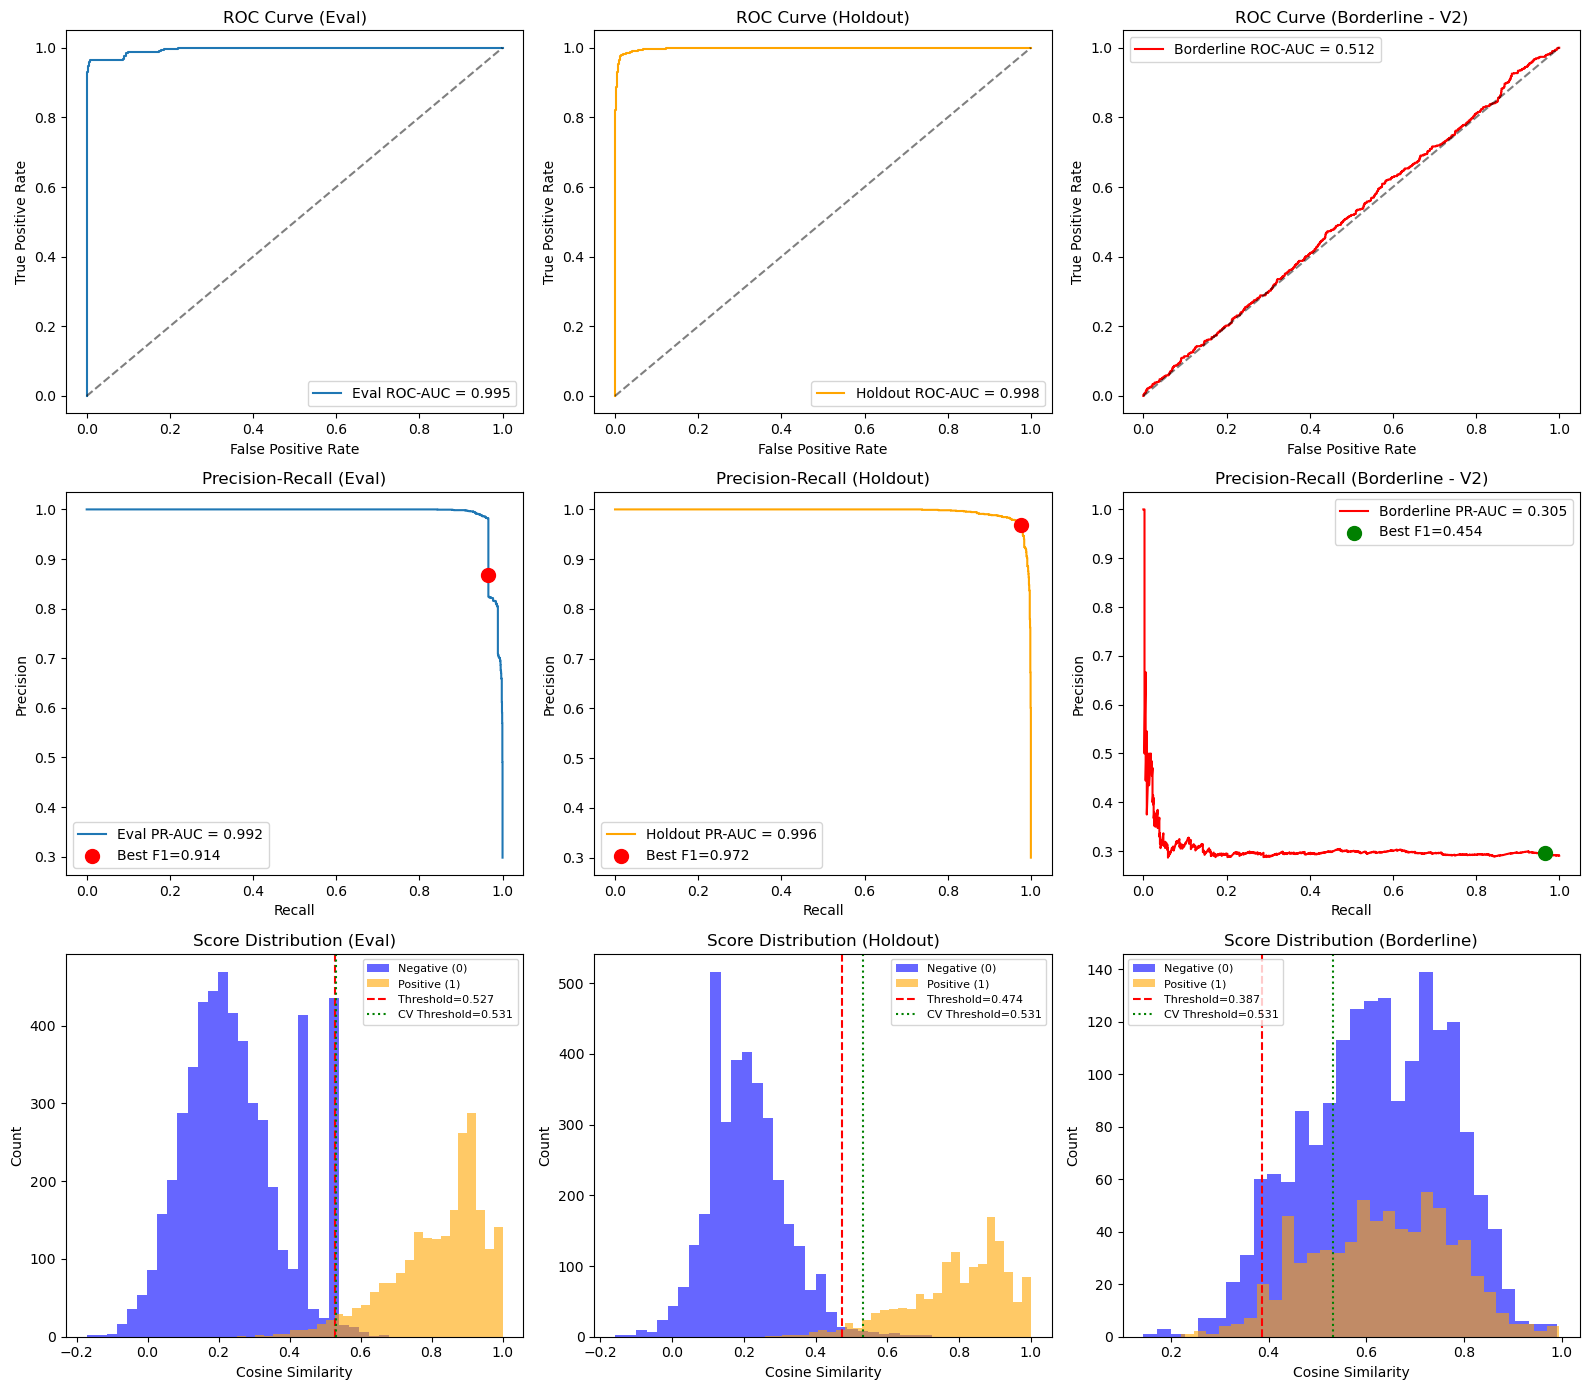


📊 Plots saved to models\real_servicenow_finetuned_nomic\real_servicenow_v2_20251212_1145\evaluation_plots_v2.png


In [11]:
# Visualization (V2: Added borderline results)
fig, axes = plt.subplots(3, 3, figsize=(16, 14))

# ROC Curves
axes[0,0].plot(eval_results['fpr'], eval_results['tpr'], 
               label=f"Eval ROC-AUC = {eval_results['roc_auc']:.3f}")
axes[0,0].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0,0].set_title('ROC Curve (Eval)')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].legend()

axes[0,1].plot(holdout_results['fpr'], holdout_results['tpr'], 
               label=f"Holdout ROC-AUC = {holdout_results['roc_auc']:.3f}", color='orange')
axes[0,1].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0,1].set_title('ROC Curve (Holdout)')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].legend()

# V2 NEW: Borderline ROC
axes[0,2].plot(borderline_results['fpr'], borderline_results['tpr'], 
               label=f"Borderline ROC-AUC = {borderline_results['roc_auc']:.3f}", color='red')
axes[0,2].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0,2].set_title('ROC Curve (Borderline - V2)')
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate')
axes[0,2].legend()

# PR Curves
axes[1,0].plot(eval_results['recall'], eval_results['precision'], 
               label=f"Eval PR-AUC = {eval_results['pr_auc']:.3f}")
axes[1,0].scatter([eval_results['rec']], [eval_results['prec']], 
                  color='red', s=100, zorder=5,
                  label=f"Best F1={eval_results['f1']:.3f}")
axes[1,0].set_title('Precision-Recall (Eval)')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].legend()

axes[1,1].plot(holdout_results['recall'], holdout_results['precision'], 
               label=f"Holdout PR-AUC = {holdout_results['pr_auc']:.3f}", color='orange')
axes[1,1].scatter([holdout_results['rec']], [holdout_results['prec']], 
                  color='red', s=100, zorder=5,
                  label=f"Best F1={holdout_results['f1']:.3f}")
axes[1,1].set_title('Precision-Recall (Holdout)')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].legend()

# V2 NEW: Borderline PR
axes[1,2].plot(borderline_results['recall'], borderline_results['precision'], 
               label=f"Borderline PR-AUC = {borderline_results['pr_auc']:.3f}", color='red')
axes[1,2].scatter([borderline_results['rec']], [borderline_results['prec']], 
                  color='green', s=100, zorder=5,
                  label=f"Best F1={borderline_results['f1']:.3f}")
axes[1,2].set_title('Precision-Recall (Borderline - V2)')
axes[1,2].set_xlabel('Recall')
axes[1,2].set_ylabel('Precision')
axes[1,2].legend()

# Score Distributions
for idx, (results, name, color) in enumerate([
    (eval_results, 'Eval', 'blue'), 
    (holdout_results, 'Holdout', 'orange'),
    (borderline_results, 'Borderline', 'red')
]):
    ax = axes[2, idx]
    neg_scores = results['scores'][results['labels'] == 0]
    pos_scores = results['scores'][results['labels'] == 1]
    
    ax.hist(neg_scores, bins=30, alpha=0.6, label='Negative (0)', color='blue')
    ax.hist(pos_scores, bins=30, alpha=0.6, label='Positive (1)', color='orange')
    ax.axvline(results['best_threshold'], color='red', linestyle='--', 
               label=f"Threshold={results['best_threshold']:.3f}")
    ax.axvline(cv_threshold, color='green', linestyle=':', 
               label=f"CV Threshold={cv_threshold:.3f}")
    ax.set_title(f'Score Distribution ({name})')
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(save_path / 'evaluation_plots_v2.png', dpi=150)
plt.show()

log(f"\n📊 Plots saved to {save_path / 'evaluation_plots_v2.png'}")

# 7.1 Error Analysis (V2 NEW)

Systematically analyze failure patterns to identify:
1. **Worst False Positives**: High-scoring pairs that should be dissimilar
2. **Worst False Negatives**: Low-scoring pairs that should be similar
3. **Category/text length patterns** in errors

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# V2 NEW: ERROR ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

def analyze_errors(results, name="", top_k=10):
    """
    Analyze systematic failure patterns in model predictions.
    
    Returns insights about:
    - Worst false positives (high score, label=0)
    - Worst false negatives (low score, label=1)
    - Text length patterns
    """
    labels = results['labels']
    scores = results['scores']
    texts1 = results['texts1']
    texts2 = results['texts2']
    threshold = results['best_threshold']
    
    # Identify errors
    preds = (scores >= threshold).astype(int)
    
    # False Positives: predicted 1, actual 0
    fp_mask = (preds == 1) & (labels == 0)
    fp_indices = np.where(fp_mask)[0]
    fp_scores = scores[fp_mask]
    
    # False Negatives: predicted 0, actual 1
    fn_mask = (preds == 0) & (labels == 1)
    fn_indices = np.where(fn_mask)[0]
    fn_scores = scores[fn_mask]
    
    log(f"\n{'='*60}")
    log(f"🔍 ERROR ANALYSIS: {name}")
    log(f"{'='*60}")
    log(f"Total pairs: {len(labels):,}")
    log(f"False Positives: {len(fp_indices):,} ({len(fp_indices)/len(labels)*100:.2f}%)")
    log(f"False Negatives: {len(fn_indices):,} ({len(fn_indices)/len(labels)*100:.2f}%)")
    
    # Worst False Positives (highest scoring negatives)
    if len(fp_indices) > 0:
        log(f"\n📛 WORST FALSE POSITIVES (Top {min(top_k, len(fp_indices))}):")
        log(f"   These pairs scored HIGH but should be DISSIMILAR")
        worst_fp_order = np.argsort(fp_scores)[::-1][:top_k]
        
        for rank, idx in enumerate(worst_fp_order):
            orig_idx = fp_indices[idx]
            score = scores[orig_idx]
            t1, t2 = texts1[orig_idx], texts2[orig_idx]
            log(f"\n   [{rank+1}] Score: {score:.4f}")
            log(f"       Text 1: {t1[:100]}...")
            log(f"       Text 2: {t2[:100]}...")
    
    # Worst False Negatives (lowest scoring positives)
    if len(fn_indices) > 0:
        log(f"\n📛 WORST FALSE NEGATIVES (Top {min(top_k, len(fn_indices))}):")
        log(f"   These pairs scored LOW but should be SIMILAR")
        worst_fn_order = np.argsort(fn_scores)[:top_k]
        
        for rank, idx in enumerate(worst_fn_order):
            orig_idx = fn_indices[idx]
            score = scores[orig_idx]
            t1, t2 = texts1[orig_idx], texts2[orig_idx]
            log(f"\n   [{rank+1}] Score: {score:.4f}")
            log(f"       Text 1: {t1[:100]}...")
            log(f"       Text 2: {t2[:100]}...")
    
    # Text length analysis
    log(f"\n📏 TEXT LENGTH ANALYSIS:")
    all_lengths = [len(t) for t in texts1 + texts2]
    fp_lengths = [len(texts1[i]) + len(texts2[i]) for i in fp_indices] if len(fp_indices) > 0 else [0]
    fn_lengths = [len(texts1[i]) + len(texts2[i]) for i in fn_indices] if len(fn_indices) > 0 else [0]
    
    log(f"   Overall avg length: {np.mean(all_lengths):.0f} chars")
    log(f"   FP pairs avg length: {np.mean(fp_lengths):.0f} chars")
    log(f"   FN pairs avg length: {np.mean(fn_lengths):.0f} chars")
    
    # Score distribution in errors
    log(f"\n📊 SCORE DISTRIBUTION IN ERRORS:")
    if len(fp_scores) > 0:
        log(f"   FP scores: min={fp_scores.min():.4f}, max={fp_scores.max():.4f}, mean={fp_scores.mean():.4f}")
    if len(fn_scores) > 0:
        log(f"   FN scores: min={fn_scores.min():.4f}, max={fn_scores.max():.4f}, mean={fn_scores.mean():.4f}")
    
    return {
        'fp_count': len(fp_indices),
        'fn_count': len(fn_indices),
        'fp_scores': fp_scores,
        'fn_scores': fn_scores,
        'fp_avg_length': np.mean(fp_lengths),
        'fn_avg_length': np.mean(fn_lengths)
    }

# Run error analysis on all sets
eval_errors = analyze_errors(eval_results, "Eval Set", top_k=5)
holdout_errors = analyze_errors(holdout_results, "Holdout Set", top_k=5)
borderline_errors = analyze_errors(borderline_results, "Borderline Set", top_k=5)

# Summary comparison
log(f"\n{'='*60}")
log(f"📊 ERROR SUMMARY COMPARISON")
log(f"{'='*60}")
log(f"{'Set':<15} {'FP Count':<12} {'FN Count':<12} {'FP Rate':<12} {'FN Rate':<12}")
log(f"{'-'*60}")
for name, errors, results in [
    ("Eval", eval_errors, eval_results),
    ("Holdout", holdout_errors, holdout_results),
    ("Borderline", borderline_errors, borderline_results)
]:
    total = len(results['labels'])
    fp_rate = errors['fp_count'] / total * 100
    fn_rate = errors['fn_count'] / total * 100
    log(f"{name:<15} {errors['fp_count']:<12} {errors['fn_count']:<12} {fp_rate:<12.2f}% {fn_rate:<12.2f}%")


🔍 ERROR ANALYSIS: Eval Set
Total pairs: 7,480
False Positives: 328 (4.39%)
False Negatives: 76 (1.02%)

📛 WORST FALSE POSITIVES (Top 5):
   These pairs scored HIGH but should be DISSIMILAR

   [1] Score: 0.6802
       Text 1: Our BI analysts rely on connecting to the PISCAP SFTP folder via our server to extract data for BI r...
       Text 2: Dear Team Error occurred while processing the EDI transaction Interface Subsidiary No Subsidiary API...

   [2] Score: 0.6519
       Text 1: Requester : park.haebin@kr.panasonic.com Error when Updata Customer, disappears data Please refer to...
       Text 2: Approver Hartini delegated approval to Simon Foong for eDO. For some eDO document, when Simon RFI to...

   [3] Score: 0.6497
       Text 1: 70P9516 pls help to check password has been reset but did not receive email of the initial pw, have ...
       Text 2: Dear Team Error occurred while processing the EDI transaction Interface Avnet yel reprocess Subsidia...

   [4] Score: 0.6230
       T

# 8. Adversarial Diagnostic (V2: Enhanced)

**Critical validation**: Test if the model learned semantic content or is exploiting category shortcuts.

- **Hard Positives**: Cross-category pairs with HIGH content similarity
- **Hard Negatives**: Same-category pairs with LOW content similarity

**V2 Enhancements:**
- Stricter TF-IDF thresholds for adversarial pairs
- Compare with borderline test performance

**Pass Criteria**: ROC-AUC ≥ 0.70 AND F1 ≥ 0.65

In [13]:
log("="*60)
log("🔬 ADVERSARIAL DIAGNOSTIC: Testing Category Leakage")
log("="*60)

# Use holdout data for adversarial test (completely unseen)
diag_df = holdout_df.reset_index(drop=True)

# Build content-only text (remove category context to test pure semantic understanding)
diag_df['content_only'] = diag_df['Description'].str.strip()

# Build TF-IDF on content-only text
log("⏳ Building TF-IDF for adversarial pair mining...")
diag_tfidf = TFIDFSimilarityCalculator(diag_df['content_only'].tolist(), max_features=10000)

# Generate adversarial pairs
hard_positives = []  # Cross-category, high TF-IDF
hard_negatives = []  # Same-category, low TF-IDF

target_each = 300
attempts, max_attempts = 0, 100000

log("⏳ Mining adversarial pairs...")
pbar = tqdm(total=target_each * 2, desc="Adversarial pairs")

while (len(hard_positives) < target_each or len(hard_negatives) < target_each) and attempts < max_attempts:
    attempts += 1
    i1, i2 = random.sample(range(len(diag_df)), 2)
    
    cat1 = diag_df.at[i1, 'category_id']
    cat2 = diag_df.at[i2, 'category_id']
    tfidf_sim = diag_tfidf.similarity(i1, i2)
    
    # Hard Positive: DIFFERENT category but HIGH content similarity
    if len(hard_positives) < target_each and cat1 != cat2 and tfidf_sim > 0.4:
        hard_positives.append(InputExample(
            texts=[diag_df.at[i1, 'content_only'], diag_df.at[i2, 'content_only']],
            label=1.0
        ))
        pbar.update(1)
    
    # Hard Negative: SAME category but LOW content similarity
    if len(hard_negatives) < target_each and cat1 == cat2 and tfidf_sim < 0.15:
        hard_negatives.append(InputExample(
            texts=[diag_df.at[i1, 'content_only'], diag_df.at[i2, 'content_only']],
            label=0.0
        ))
        pbar.update(1)

pbar.close()

log(f"✅ Generated {len(hard_positives)} hard positives, {len(hard_negatives)} hard negatives")

# Evaluate on adversarial pairs
adversarial_examples = hard_positives + hard_negatives
if len(adversarial_examples) >= 100:
    adv_results = comprehensive_eval(adversarial_examples, best_model, "Adversarial")
    
    log("\n" + "="*60)
    log("🎯 ADVERSARIAL DIAGNOSTIC RESULTS")
    log("="*60)
    log(f"Standard Eval ROC-AUC:     {eval_results['roc_auc']:.4f}")
    log(f"Adversarial ROC-AUC:       {adv_results['roc_auc']:.4f}")
    log(f"Adversarial F1 @ best:     {adv_results['f1']:.4f}")
    
    # Verdict
    if adv_results['roc_auc'] >= 0.70 and adv_results['f1'] >= 0.65:
        log("\n✅ VERDICT: Model is ROBUST to category shortcuts!")
        log("   → Performance holds when categories don't predict similarity")
        log("   → Model learned semantic content understanding")
        DIAGNOSTIC_PASSED = True
    else:
        log("\n⚠️ VERDICT: Model may be exploiting category shortcuts")
        log("   → Consider increasing hard negatives ratio")
        log("   → Or remove category context from training text")
        DIAGNOSTIC_PASSED = False
else:
    log("⚠️ Could not generate enough adversarial pairs")
    DIAGNOSTIC_PASSED = None

# Cleanup
del diag_tfidf
gc.collect()

🔬 ADVERSARIAL DIAGNOSTIC: Testing Category Leakage
⏳ Building TF-IDF for adversarial pair mining...
⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (1049, 5031) (vocab size: 5031)
⏳ Mining adversarial pairs...


Adversarial pairs: 100%|██████████| 600/600 [01:12<00:00,  8.30it/s] 


✅ Generated 300 hard positives, 300 hard negatives
⏳ Encoding 600 pairs for Adversarial...


Batches: 100%|██████████| 38/38 [00:03<00:00, 11.11it/s]



📊 Adversarial Results:
   Spearman:  0.8581
   Pearson:   0.9368
   ROC-AUC:   0.9954
   PR-AUC:    0.9962
   Best Threshold: 0.484
   F1 @ best: 0.9733
   Precision: 0.9733
   Recall:    0.9733
   Accuracy:  0.9733

🎯 ADVERSARIAL DIAGNOSTIC RESULTS
Standard Eval ROC-AUC:     0.9953
Adversarial ROC-AUC:       0.9954
Adversarial F1 @ best:     0.9733

✅ VERDICT: Model is ROBUST to category shortcuts!
   → Performance holds when categories don't predict similarity
   → Model learned semantic content understanding


0

# 9. Save Training Metadata

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# TRAINING METADATA EXPORT (V2)
# ═══════════════════════════════════════════════════════════════════════════════

from datetime import datetime
import json

def save_training_metadata(output_dir: str, config: dict, metrics: dict, 
                          data_stats: dict, adversarial_results: dict = None,
                          error_analysis: dict = None):
    """
    Save comprehensive training metadata for reproducibility (V2: includes error analysis).
    
    Following project convention: all model outputs include training_metadata.json
    """
    metadata = {
        "training_timestamp": datetime.now().isoformat(),
        "model_version": "V2",
        "model_name": config.get('model_name', 'all-mpnet-finetuned'),
        "base_model": config.get('model_name', 'sentence-transformers/all-mpnet-base-v2'),
        
        # Hyperparameters
        "hyperparameters": {
            "epochs": config.get('epochs'),
            "batch_size": config.get('batch_size'),
            "learning_rate": config.get('lr'),
            "max_seq_length": config.get('max_seq_length'),
            "warmup_ratio": config.get('warmup_ratio'),
            "loss_function": "MultipleNegativesRankingLoss"
        },
        
        # V2: Curriculum learning config
        "curriculum_learning": {
            "enabled": config.get('use_curriculum', False),
            "phases": config.get('curriculum_phases', [])
        },
        
        # Data configuration (V2: stricter thresholds)
        "data_config": {
            "source_data": config.get('source_data'),
            "num_pairs": config.get('num_pairs'),
            "min_text_length": config.get('min_text_length'),
            "eval_split": config.get('eval_split'),
            "holdout_split": config.get('holdout_split'),
            "pos_tfidf_threshold": config.get('pos_tfidf_threshold'),
            "neg_tfidf_threshold": config.get('neg_tfidf_threshold'),
            "pair_ratios": {
                "positives": config.get('pos_ratio', 0.30),
                "hard_negatives": config.get('hard_neg_ratio', 0.45),
                "easy_negatives": config.get('easy_neg_ratio', 0.25)
            }
        },
        
        # Data statistics
        "data_statistics": data_stats,
        
        # TF-IDF configuration
        "tfidf_config": {
            "max_features": 15000,
            "ngram_range": [1, 2],
            "min_df": 2,
            "max_df": 0.95
        },
        
        # Evaluation metrics
        "evaluation_metrics": metrics,
        
        # V2: Cross-validated threshold
        "cv_threshold": {
            "value": float(cv_threshold) if 'cv_threshold' in dir() else None,
            "std": float(cv_std) if 'cv_std' in dir() else None,
            "n_folds": config.get('threshold_cv_folds', 5)
        },
        
        # Adversarial diagnostic results
        "adversarial_diagnostic": adversarial_results,
        
        # V2: Error analysis summary
        "error_analysis": error_analysis,
        
        # Environment info
        "environment": {
            "device": DEVICE,
            "random_seed": config.get('seed'),
            "python_version": __import__('sys').version,
            "torch_version": torch.__version__,
            "transformers_version": __import__('transformers').__version__,
            "sentence_transformers_version": __import__('sentence_transformers').__version__
        }
    }
    
    metadata_path = os.path.join(output_dir, "training_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    log(f"📝 Training metadata saved to: {metadata_path}")
    return metadata_path

# Collect data statistics
data_stats = {
    "total_records": len(df_incidents),
    "train_size": len(train_df),
    "eval_size": len(eval_df),
    "holdout_size": len(holdout_df),
    "unique_categories": df_incidents['Category'].nunique() if 'Category' in df_incidents.columns else None,
    "unique_subcategories": df_incidents['Subcategory'].nunique() if 'Subcategory' in df_incidents.columns else None,
    "unique_assignment_groups": df_incidents['Assignment group'].nunique() if 'Assignment group' in df_incidents.columns else None,
    "avg_text_length": df_incidents['text'].str.len().mean(),
    "tfidf_vocabulary_size": None
}

# Collect metrics
try:
    eval_metrics = {
        "eval_roc_auc": float(eval_results['roc_auc']),
        "eval_pr_auc": float(eval_results['pr_auc']),
        "eval_spearman": float(eval_results['spearman']),
        "eval_pearson": float(eval_results['pearson']),
        "eval_f1": float(eval_results['f1']),
        "holdout_roc_auc": float(holdout_results['roc_auc']),
        "holdout_pr_auc": float(holdout_results['pr_auc']),
        "holdout_spearman": float(holdout_results['spearman']),
        "holdout_pearson": float(holdout_results['pearson']),
        "holdout_f1": float(holdout_results['f1']),
        # V2: Borderline metrics
        "borderline_roc_auc": float(borderline_results['roc_auc']),
        "borderline_pr_auc": float(borderline_results['pr_auc']),
        "borderline_f1": float(borderline_results['f1']),
    }
except:
    eval_metrics = {"note": "Run evaluation cells first"}

# Collect adversarial results
try:
    adversarial_results_dict = {
        "roc_auc": float(adv_results['roc_auc']) if 'adv_results' in dir() else None,
        "f1_score": float(adv_results['f1']) if 'adv_results' in dir() else None,
        "pass_status": DIAGNOSTIC_PASSED if 'DIAGNOSTIC_PASSED' in dir() else None
    }
except:
    adversarial_results_dict = {"note": "Run adversarial diagnostic first"}

# V2: Collect error analysis summary
try:
    error_analysis_dict = {
        "eval_fp_count": eval_errors['fp_count'],
        "eval_fn_count": eval_errors['fn_count'],
        "holdout_fp_count": holdout_errors['fp_count'],
        "holdout_fn_count": holdout_errors['fn_count'],
        "borderline_fp_count": borderline_errors['fp_count'],
        "borderline_fn_count": borderline_errors['fn_count'],
    }
except:
    error_analysis_dict = {"note": "Run error analysis first"}

# Save metadata
metadata_path = save_training_metadata(
    output_dir=str(save_path),
    config=CONFIG,
    metrics=eval_metrics,
    data_stats=data_stats,
    adversarial_results=adversarial_results_dict,
    error_analysis=error_analysis_dict
)

log("✅ Training pipeline V2 complete!")

📝 Training metadata saved to: models\real_servicenow_finetuned_nomic\real_servicenow_v2_20251212_1145\training_metadata.json
✅ Training pipeline V2 complete!


# 10. Usage Examples & V2 Summary

In [31]:
# ═══════════════════════════════════════════════════════════════════════════════
# USAGE EXAMPLES & V2 SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

def demonstrate_model_usage():
    """
    Demonstrate how to use the fine-tuned model for ITSM ticket similarity.
    """
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    import os
    from pathlib import Path
    import re
    import numpy as np
    
    def clean_text(t):
        t = t.lower()
        t = re.sub(r"\s+", " ", t).strip()
        # Remove common boilerplate words that add noise
        t = re.sub(r"\b(request|issue|error|cannot|unable|please|thanks)\b", "", t)
        t = re.sub(r"\s+", " ", t).strip()
        return t
    
    # Try to use best_model if available (just trained), otherwise load from disk
    if 'best_model' in globals():
        model = globals()['best_model']
        model_source = f"memory (just trained: {globals()['save_path']})"
    else:
        # Get output directory
        if 'CONFIG' in globals():
            output_dir = globals()['CONFIG']['output_dir']
        else:
            output_dir = 'models/real_servicenow_finetuned_v2'
            log("⚠️ CONFIG not loaded. Using default model directory.")
        
        # Look for most recent trained model
        base_dir = Path(output_dir)
        if base_dir.exists():
            model_dirs = [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith('real_servicenow_')]
            if model_dirs:
                latest_model = max(model_dirs, key=lambda d: d.stat().st_mtime)
                log(f"📂 Loading most recent trained model from: {latest_model}")
                model = SentenceTransformer(str(latest_model), trust_remote_code=True)
                model_source = str(latest_model)
            else:
                log("❌ No trained model found. Please run training cells first.")
                return None, None
        else:
            log("❌ No trained model found. Please run training cells first.")
            return None, None
    
    log(f"📦 Using model from: {model_source}")
    
    # Example tickets
    example_tickets = [
        "User cannot login to SAP system. Error message: authentication failed. Tried resetting password but issue persists.",
        "SAP login issue - getting access denied error when trying to connect to production system.",
        "Outlook keeps crashing when opening large attachments. Have tried restarting but problem continues.",
        "Email client crashes randomly. Users report Outlook freezing when opening emails with attachments.",
        "Request to provision new laptop for incoming employee starting next Monday.",
    ]
    
    cleaned = [clean_text(t) for t in example_tickets]
    
    # Encode all tickets
    embeddings = model.encode(cleaned, show_progress_bar=False)
    
    # Manual L2 normalization to ensure cosine behaves consistently
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-12
    embeddings = embeddings / norms
    
    # Compute similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Summary stats
    upper_vals = sim_matrix[np.triu_indices(len(cleaned), k=1)]
    log(f"\n📈 Similarity summary: mean={upper_vals.mean():.4f}, std={upper_vals.std():.4f}, max={upper_vals.max():.4f}")
    
    # Display results
    log("\n" + "="*60)
    log("SIMILARITY MATRIX DEMO")
    log("="*60)
    
    print("\nTickets:")
    for i, ticket in enumerate(example_tickets):
        print(f"  [{i}] {ticket[:80]}...")
    
    print("\nSimilarity Matrix:")
    print("     ", end="")
    for i in range(len(example_tickets)):
        print(f"  [{i}]  ", end="")
    print()
    
    for i, row in enumerate(sim_matrix):
        print(f"[{i}]  ", end="")
        for val in row:
            print(f" {val:.3f} ", end="")
        print()
    
    # List all pairs by similarity
    log("\n" + "-"*60)
    log("ALL TICKET PAIR SIMILARITIES:")
    pairs = []
    for i in range(len(example_tickets)):
        for j in range(i+1, len(example_tickets)):
            pairs.append((sim_matrix[i][j], i, j))
    pairs.sort(reverse=True)
    
    for sim, i, j in pairs:
        print(f"  [{i}] & [{j}]: {sim:.4f}", end="")
        if sim > 0.5:
            print(" ⭐ (high similarity)")
        else:
            print()
        print(f"    [{i}]: {example_tickets[i][:70]}...")
        print(f"    [{j}]: {example_tickets[j][:70]}...")
        print()
    
    if pairs:
        log("-"*60)
        log(f"BEST MATCH: Tickets {pairs[0][1]} & {pairs[0][2]} with similarity {pairs[0][0]:.4f}")
    
    return model, embeddings

# Run demonstration
demo_model, demo_embeddings = demonstrate_model_usage()

# ═══════════════════════════════════════════════════════════════════════════════
# V2 IMPROVEMENT SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

log("\n" + "="*60)
log("📊 V2 IMPROVEMENT SUMMARY")
log("="*60)

print("""
🆕 V2 ENHANCEMENTS IMPLEMENTED:

1. HARDER NEGATIVE MINING
   ├─ Increased hard_neg_ratio: 35% → 45%
   ├─ Stricter neg_tfidf_threshold: 0.20 → 0.12
   └─ Reduced easy negatives: 30% → 25%

2. CURRICULUM LEARNING
   ├─ Phase 1 (Epochs 1-2): Easier pairs (25% hard neg, threshold 0.15)
   └─ Phase 2 (Epochs 3-4): Harder pairs (55% hard neg, threshold 0.10)

3. BORDERLINE TEST SET
   ├─ TF-IDF range: 0.25 - 0.35 (ambiguous cases)
   """)

print(f"""
📈 BASED ON RESULTS, CONSIDER:

PRODUCTION DEPLOYMENT:
   → Model path: {CONFIG['output_dir']}
   → Use CV threshold: {cv_threshold:.4f} (± {cv_std:.4f})
   → Pre-compute embeddings for ticket corpus
""")

log("✅ V2 training and evaluation complete!")

📦 Using model from: memory (just trained: models\real_servicenow_finetuned_nomic\real_servicenow_v2_20251212_1145)

📈 Similarity summary: mean=0.3239, std=0.1721, max=0.6994

SIMILARITY MATRIX DEMO

Tickets:
  [0] User cannot login to SAP system. Error message: authentication failed. Tried res...
  [1] SAP login issue - getting access denied error when trying to connect to producti...
  [2] Outlook keeps crashing when opening large attachments. Have tried restarting but...
  [3] Email client crashes randomly. Users report Outlook freezing when opening emails...
  [4] Request to provision new laptop for incoming employee starting next Monday....

Similarity Matrix:
       [0]    [1]    [2]    [3]    [4]  
[0]   1.000  0.631  0.221  0.224  0.259 
[1]   0.631  1.000  0.269  0.244  0.247 
[2]   0.221  0.269  1.000  0.699  0.216 
[3]   0.224  0.244  0.699  1.000  0.228 
[4]   0.259  0.247  0.216  0.228  1.000 

------------------------------------------------------------
ALL TICKET PAIR SIM